In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

from sklearn import neighbors
from sklearn import linear_model
from sklearn.cross_decomposition import PLSRegression

%matplotlib inline


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,acidity_citric_density,sulfur_combo
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,-0.453711,-0.422530
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,-0.553746,0.748267
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,-0.449977,0.072666
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1.267366,0.259465
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,-0.453711,-0.422530


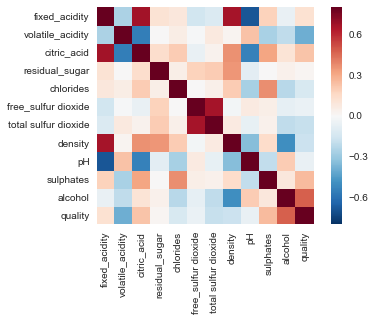

In [144]:
df_wine = pd.read_csv(filepath_or_buffer='winequality-red.csv', delimiter=',')
df_wine.head()

corr_raw = df_wine.corr()
sns.heatmap(corr_raw, vmax=.8, square=True)

means = df_wine[['fixed_acidity','citric_acid','density']].mean(axis=0)
stds = df_wine[['fixed_acidity','citric_acid','density']].std(axis=0)

#print(means,stds)
df_wine['acidity_citric_density'] = (((df_wine[['fixed_acidity','citric_acid','density']] - means) / stds).mean(axis=1))
#features['trust_fair_help'] = ((df[['ppltrst','pplfair','pplhlp']] - means) / stds).mean(axis=1)

means_sulfur = df_wine[['free_sulfur dioxide','total sulfur dioxide']].mean(axis=0)
stds_sulfur = df_wine[['free_sulfur dioxide','total sulfur dioxide']].std(axis=0)

#print(means,stds)
df_wine['sulfur_combo'] = (((df_wine[['free_sulfur dioxide','total sulfur dioxide']] - means_sulfur) / stds_sulfur).mean(axis=1))
#features['trust_fair_help'] = ((df[['ppltrst','pplfair','pplhlp']] - means) / stds).mean(axis=1)

df_wine.head()




In [119]:
# get baseline for predictive of quality - all features

raw_features = df_wine.drop(['quality'],axis=1)
raw_target = df_wine.filter(['quality'],axis=1)

regr.fit(raw_features, raw_target)
Y_pred = regr.predict(raw_features)
print('R-squared regression:', regr.score(raw_features, raw_target))

R-squared regression: 0.360551703039


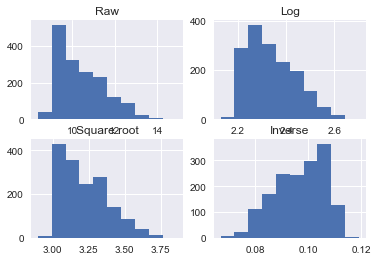

In [137]:
# Check for normality Making a four-panel plot. (testing each feature - recording results in comment)
# pH already looks normally distributed
# square root of volatile acidity seems to create a more normal distribution
# inverse of sugar more normal distribution
# acidity_citric_density reasonably normally distributed raw
#inverse of sulphates looks more normally distributed
# log of chlorides looks more normally distributed
# log of alcohol looks a little better

fig = plt.figure()

fig.add_subplot(221)
plt.hist(df_wine['alcohol'].dropna())
plt.title('Raw')

fig.add_subplot(222)
plt.hist(np.log(df_wine['alcohol'].dropna()))
plt.title('Log')

ax2=fig.add_subplot(223)
plt.hist(np.sqrt(df_wine['alcohol'].dropna()))
plt.title('Square root')

ax3=fig.add_subplot(224)
plt.hist(1/df_wine['alcohol'].dropna())
plt.title('Inverse')
plt.show()

In [143]:
# try transforming data based on plots


features_transformed = df_wine.drop(['fixed_acidity','volatile_acidity','residual_sugar','sulphates','alcohol','free_sulfur dioxide', \
                                     'total sulfur dioxide','density','citric_acid','chlorides','quality'],axis=1)
features_transformed['chlorides'] = np.log(df_wine['chlorides'])
features_transformed['alcohol'] = np.log(df_wine['alcohol'])
features_transformed['volatile_acidity'] = np.sqrt(df_wine['volatile_acidity'])
features_transformed['residual_sugar'] = 1 / df_wine['residual_sugar']
features_transformed['sulphates'] = 1 / df_wine['sulphates']
features_transformed.head()

regr.fit(features_transformed, raw_target)
Y_pred = regr.predict(features_transformed)
print('R-squared regression:', regr.score(features_transformed, raw_target))



R-squared regression: 0.370388879909


### Slightly better R-Squared after transforming data - look at correlation again


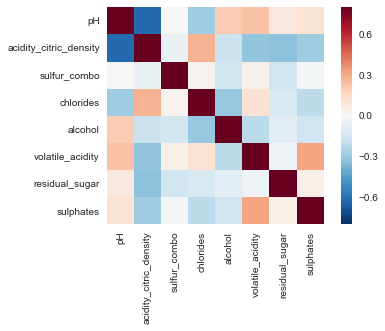

In [145]:
corr_transformed = features_transformed.corr()
sns.heatmap(corr_transformed, vmax=.8, square=True)

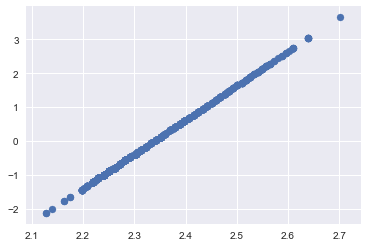

                 pH  acidity_citric_density  sulfur_combo     chlorides  \
count  1.599000e+03            1.599000e+03  1.599000e+03  1.599000e+03   
mean   3.002879e-15           -2.272867e-16 -4.218014e-17  1.401492e-15   
std    1.000313e+00            1.000313e+00  1.000313e+00  1.000313e+00   
min   -3.700401e+00           -2.519268e+00 -1.347991e+00 -5.861545e+00   
25%   -6.551405e-01           -7.088258e-01 -8.031127e-01 -4.701690e-01   
50%   -7.212705e-03           -1.480210e-01 -2.319377e-01 -1.004110e-01   
75%    5.759223e-01            5.924893e-01  6.396973e-01  2.981114e-01   
max    4.528282e+00            3.995097e+00  5.170690e+00  6.153238e+00   

            alcohol  volatile_acidity  residual_sugar     sulphates  \
count  1.599000e+03      1.599000e+03    1.599000e+03  1.599000e+03   
mean  -1.075507e-16      8.179129e-16   -6.877967e-16 -3.638081e-16   
std    1.000313e+00      1.000313e+00    1.000313e+00  1.000313e+00   
min   -2.132012e+00     -3.007363e+00   

In [146]:
# try normalizing the features/target 
from sklearn import preprocessing

df_num = features_transformed
df_num['quality'] = df_wine['quality']

# Select only numeric variables to scale.
df_num = df_num.select_dtypes(include=[np.number]).dropna()
df_num.head()

#Save the column names.
names=df_num.columns

# Scale, then turn the resulting numpy array back into a data frame with the
# correct column names.
df_scaled = pd.DataFrame(preprocessing.scale(df_num), columns=names)
# The new features contain all the information of the old ones, but on a new scale.
plt.scatter(df_num['alcohol'], df_scaled['alcohol'])
plt.show()

# Lookit all those matching means and standard deviations!
print(df_scaled.describe())

In [147]:
# run regression on normalized data

features_scaled = df_scaled.drop(['quality'],axis=1)
target_scaled = df_scaled.filter(['quality'],axis=1)

regr.fit(features_scaled, target_scaled)
Y_pred = regr.predict(features_scaled)
print('R-squared regression:', regr.score(features_scaled, target_scaled))

R-squared regression: 0.370388879909


In [159]:
# Build our model with KNN.

knn = neighbors.KNeighborsRegressor(n_neighbors=15)
knn_features = features_scaled
knn_target = target_scaled

knn.fit(knn_features, knn_target)

knn_w = neighbors.KNeighborsRegressor(n_neighbors=15, weights='distance')

knn_w.fit(knn_features, knn_target)

# Set up our prediction line.
# T_quality = np.arange(0, 7, 0.1)[:, np.newaxis]
# T_quality = T_quality.reshape(1,-1)

# Trailing underscores are a common convention for a prediction.
Y_ = knn.predict(knn_features)

from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, knn_features, knn_target, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

score_w = cross_val_score(knn_w, knn_features, knn_target, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score.std() * 2))

Unweighted Accuracy: 0.28 (+/- 0.13)
Weighted Accuracy: 0.28 (+/- 0.13)


(array([  10.,    0.,   53.,    0.,  681.,    0.,  638.,    0.,  199.,   18.]),
 array([ 3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5,  8. ]),
 <a list of 10 Patch objects>)

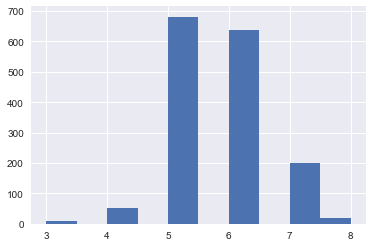

In [161]:
plt.hist(df_wine['quality'],bins=10)

write a few paragraphs to describe the models' behaviors and why you favor one model or the other. Try to determine whether there is a situation where you would change your mind, or whether one is unambiguously better than the other. Lastly, try to note what it is about the data that causes the better model to outperform the weaker model. Submit a link to your notebook below.

####  Overall the OLS model was unamiguously better at predicting wine quality than the nearest neighbor model. However, neither model was very good.  The vast majority of wines were rated as a 5 or a 6 which limited the variation in outcome on which to train the data. It's possible that looking for nearest neighbors in this case would result in a poorer performance than a regression since NN takes a discrete number of data points (which probably don't explain the difference between ratings 5 and 6 very well). The regression looks for an overall pattern using all the data so may have performed slightly better.  A classifier may have worked better to predict wine quality in this case.